
# ATSC PBIL: Pipeline Notebook

Notebook này chạy tuần tự các bước:
1) Build **net-info file** và **tls-candidates** → `net-info.json`, `tls-candidates.json`
2) **Chạy baselines** (No-ATSC / All-ATSC)  
3) **Chạy thuật toán lựa chọn nút giao** (PBIL)
4) **Chạy đánh giá kết quả** (Evaluate)
5) **Tổng hợp & trực quan hoá** kết quả

> Gợi ý: đặt file này vào thư mục `scripts/` của repo: `scripts/atsc_pipeline.ipynb`.

### 0. Setup Environment

In [10]:
# Install dependencies
!poetry install
# Import libraries dependencies
import subprocess
import json
import os
from IPython.display import Image, display
from datetime import datetime

Installing dependencies from lock file

No dependencies to install or update

Installing the current project: choose-atsc-pbil (0.1.0)


In [11]:
# Setup path run
PROJECT_ROOT = "E:/VTS/ITS/Choose ATSC/Software/choose_ATSC_PBIL"
%cd {PROJECT_ROOT}

# Setup path for SUMO
SUMO_HOME = os.environ.get('SUMO_HOME', '/usr/share/sumo')

# Setup config file
CONFIG_FILE = os.path.join(PROJECT_ROOT, "configs", "config.json")

# Setup run dir:
RUN_DIR = os.path.join("data", "results", "runs", datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

# Print detail
print(f"Project root: {PROJECT_ROOT}")
print(f"SUMO home: {SUMO_HOME}")
print(f"Run dir: {RUN_DIR}")

# Load Config
with open(CONFIG_FILE, "r") as f:
    config = json.load(f)


E:\VTS\ITS\Choose ATSC\Software\choose_ATSC_PBIL
Project root: E:/VTS/ITS/Choose ATSC/Software/choose_ATSC_PBIL
SUMO home: C:\Program Files (x86)\Eclipse\Sumo\
Run dir: data\results\runs\2025-08-19_17-29-07


In [12]:
# Function for running a command
def run_command(cmd):
    """
    Chạy một command (list hoặc string) và stream output ra stdout theo thời gian thực.
    
    Args:
        cmd (list[str] | str): lệnh cần chạy, ví dụ:
            ["poetry", "run", "run-baselines", "--config", "configs/config.json"]
            hoặc "poetry run run-baselines --config configs/config.json"
    """
    if isinstance(cmd, str):
        shell = True
    else:
        shell = False

    process = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        encoding="utf-8",
        errors="replace",
        bufsize=1,
        shell=shell
    )

    for line in process.stdout:
        print(line, end="")  # stream ngay
    process.wait()
    return process.returncode


### 1. Build net-info and tls-candidate files

Sinh `net-info.json` (No-ATSC / All-ATSC).

In [8]:
# ============ Build net-info ============
run_command(["poetry", "run", "build-net-info", "--net", config['sumo']['net_file'], "--detectors", config['sumo']['detectors_file'], "--out", config['sumo']['net_info_file']])

✅ Đã tạo: data/input/sumo/PhuQuoc_v2/net-info.json


0

Sinh `tls-candidates.json`

In [9]:
# ============ Build tls-candidates ============
run_command(["poetry", "run", "build-tls-candidates", "--net", config["sumo"]["net_file"], "--out", config["sumo"]["candidates_file"]])

✅ Đã tạo:  data/input/sumo/PhuQuoc_v2/tls-candidates.json


0

### 2. Run PBIL Algorithm

Chạy `run_pbil.py` để sinh ra các file kết quả cho thuật toán PBIL.

In [17]:
# ============= Run PBIL Algorithm =============
run_command(["poetry", "run", "run-pbil", "--config", "configs/config.json", "--output", RUN_DIR])

2025-08-19 17:44:21 [INFO] ========== Starting choose ATSC using PBIL ==========
2025-08-19 17:44:21 [INFO] __________ Setting up configuration __________
2025-08-19 17:44:21 [INFO] Loaded configuration from: configs/config.json
2025-08-19 17:44:21 [INFO] Loaded network information from: data/input/sumo/PhuQuoc_v2/net-info.json
2025-08-19 17:44:21 [INFO] Loaded candidate TLS IDs from: data/input/sumo/PhuQuoc_v2/tls-candidates.json
2025-08-19 17:44:21 [INFO] Setting up run directory: data/results/runs/2025-08-19_17-29-07
2025-08-19 17:44:21 [INFO] Setting up PBIL and SUMO...
2025-08-19 17:44:21 [INFO] Using up to 16 parallel processes
2025-08-19 17:44:21 [INFO] __________ Generation 1/5: Starting __________
2025-08-19 17:44:22 [INFO] Waiting for 5 process(es) to complete...
2025-08-19 17:44:28 [INFO] Best:  [1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1] -> Score: 50.000000
2025-08-19 17:44:28 [INFO] Worst: [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1] -> Score: 50.000000
2025-08-19 17:44:28 [INFO] U

0

### 3. Evaluation Baseline and PBIL Results

Chạy `evaluate.py` để đánh giá kết quả của các thuật toán (all-ATSC, no-ATSC, PBIL)

In [ ]:
# ============= No ATSC =============
run_command(["poetry", "run", "evaluation", "--config", CONFIG_FILE, "--output", RUN_DIR])

Figure(640x480)


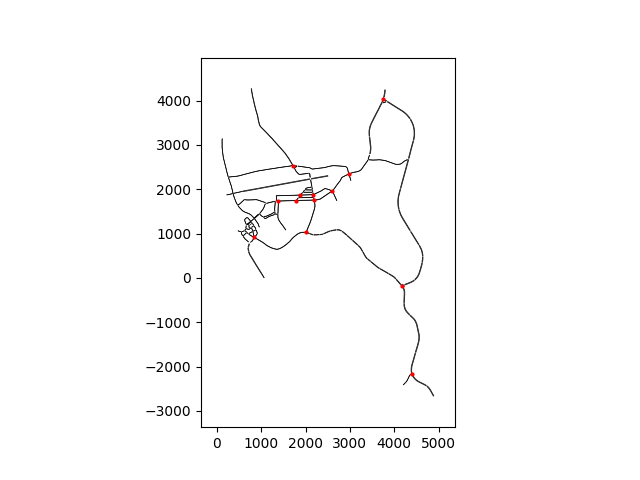

In [16]:
randomTrip = os.path.join(SUMO_HOME, 'tools', 'visualization', 'plot_net_trafficLights.py')
filename = os.path.join(RUN_DIR, 'ATSC_map.png')
run_command(["poetry", "run", "python", randomTrip, '-n', 'data/input/sumo/PhuQuoc_v2/phuquoc.net.xml', '--edge-width', '.5', '--width', '2', '-o', filename])
display(Image(filename=filename))

In [44]:
!python 'C:\Program Files (x86)\Eclipse\Sumo\tools\plot_trajectories.py' -t xy -o allLocations_output.png fcd.xml

C:\Users\NghiaNL\.pyenv\pyenv-win\versions\3.12.4\python.exe: can't open file "E:\\VTS\\ITS\\Choose ATSC\\Software\\choose_ATSC_PBIL\\'C:\\Program": [Errno 22] Invalid argument


In [11]:
%load_ext autoreload
%autoreload 2

import os
import json
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()   # tùy chỉnh theo vị trí notebook
CONFIGS_DIR = PROJECT_ROOT / "configs"
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = DATA_DIR / "results" / "runs"

print("Project root:", PROJECT_ROOT)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project root: E:\VTS\ITS\Choose ATSC\Software\choose_ATSC_PBIL


In [3]:
import subprocess
build_cmd = [
    "poetry", "run", "run-baseline"
]
print("Building graph.json & tls_candidates.json...")
subprocess.run(build_cmd, check=True)


Building graph.json & tls_candidates.json...


CalledProcessError: Command '['poetry', 'run', 'run-baseline']' returned non-zero exit status 1.

In [5]:
%%capture cap
!python src/cli/run_baselines.py --config ../configs/experiment.example.json

### 3) Visualize Results

Installing dependencies from lock file

No dependencies to install or update

Installing the current project: choose-atsc-pbil (0.1.0)


In [ ]:
# Run NO-ATSC baseline
!poetry run run-custom --config "$path_folder/configs/configs.json" --net_info "$path_folder/net_info.json"

: 